In [166]:
import pandas as pd

# 读取IMU数据文件
file_path = '../data/s15_a9_t1_u.csv'
imu_data = pd.read_csv(file_path)

# 查看列名
print(imu_data.columns)

# 提取与RU和RF相关的列
columns_to_keep = [
    'timestamp',  # 如果你想保留时间戳
    'RU_IMU9_Acc_X', 'RU_IMU9_Acc_Y', 'RU_IMU9_Acc_Z',
    'RU_IMU9_Gyro_X', 'RU_IMU9_Gyro_Y', 'RU_IMU9_Gyro_Z',
    'RU_IMU9_Magn_X', 'RU_IMU9_Magn_Y', 'RU_IMU9_Magn_Z',
    'RF_IMU9_Acc_X', 'RF_IMU9_Acc_Y', 'RF_IMU9_Acc_Z',
    'RF_IMU9_Gyro_X', 'RF_IMU9_Gyro_Y', 'RF_IMU9_Gyro_Z',
    'RF_IMU9_Magn_X', 'RF_IMU9_Magn_Y', 'RF_IMU9_Magn_Z'
]

# 删除其他列，只保留指定的列
filtered_imu_data = imu_data[columns_to_keep]

# 删除包含缺失值的行
filtered_imu_data_cleaned = filtered_imu_data.dropna()

# 将处理后的数据存储到新的CSV文件中
output_file_path = '../data/s15_arm.csv'
filtered_imu_data_cleaned.to_csv(output_file_path, index=False)

print(f"已成功将处理后的数据存储到文件: {output_file_path}")


Index(['relative_id', 'timestamp', 'CHS_IMU9_Acc_X', 'CHS_IMU9_Acc_Y',
       'CHS_IMU9_Acc_Z', 'CHS_IMU9_Gyro_X', 'CHS_IMU9_Gyro_Y',
       'CHS_IMU9_Gyro_Z', 'CHS_IMU9_Magn_X', 'CHS_IMU9_Magn_Y',
       'CHS_IMU9_Magn_Z', 'RF_IMU9_Acc_X', 'RF_IMU9_Acc_Y', 'RF_IMU9_Acc_Z',
       'RF_IMU9_Gyro_X', 'RF_IMU9_Gyro_Y', 'RF_IMU9_Gyro_Z', 'RF_IMU9_Magn_X',
       'RF_IMU9_Magn_Y', 'RF_IMU9_Magn_Z', 'LU_IMU9_Acc_X', 'LU_IMU9_Acc_Y',
       'LU_IMU9_Acc_Z', 'LU_IMU9_Gyro_X', 'LU_IMU9_Gyro_Y', 'LU_IMU9_Gyro_Z',
       'LU_IMU9_Magn_X', 'LU_IMU9_Magn_Y', 'LU_IMU9_Magn_Z', 'LF_IMU9_Acc_X',
       'LF_IMU9_Acc_Y', 'LF_IMU9_Acc_Z', 'LF_IMU9_Gyro_X', 'LF_IMU9_Gyro_Y',
       'LF_IMU9_Gyro_Z', 'LF_IMU9_Magn_X', 'LF_IMU9_Magn_Y', 'LF_IMU9_Magn_Z',
       'RU_IMU9_Acc_X', 'RU_IMU9_Acc_Y', 'RU_IMU9_Acc_Z', 'RU_IMU9_Gyro_X',
       'RU_IMU9_Gyro_Y', 'RU_IMU9_Gyro_Z', 'RU_IMU9_Magn_X', 'RU_IMU9_Magn_Y',
       'RU_IMU9_Magn_Z'],
      dtype='object')
已成功将处理后的数据存储到文件: ../data/s15_arm.csv


In [138]:
##############################根据IMU数据计算四元数##############################

import numpy as np
from ahrs.filters import Madgwick
import pandas as pd
from scipy.ndimage import gaussian_filter1d

# 读取stable.csv文件
file_path = '../data/stable.csv'  # 请修改为你实际的文件路径
data = pd.read_csv(file_path)

# 时间戳列
timestamps = data['timestamp'].values

# 选择需要的列
acc_ru = data[['RU_IMU9_Acc_X', 'RU_IMU9_Acc_Y', 'RU_IMU9_Acc_Z']].values
gyro_ru = data[['RU_IMU9_Gyro_X', 'RU_IMU9_Gyro_Y', 'RU_IMU9_Gyro_Z']].values
mag_ru = data[['RU_IMU9_Magn_X', 'RU_IMU9_Magn_Y', 'RU_IMU9_Magn_Z']].values

acc_rf = data[['RF_IMU9_Acc_X', 'RF_IMU9_Acc_Y', 'RF_IMU9_Acc_Z']].values
gyro_rf = data[['RF_IMU9_Gyro_X', 'RF_IMU9_Gyro_Y', 'RF_IMU9_Gyro_Z']].values
mag_rf = data[['RF_IMU9_Magn_X', 'RF_IMU9_Magn_Y', 'RF_IMU9_Magn_Z']].values

# 左手坐标系转换为右手坐标系 (翻转Z轴)
acc_ru[:, 2] = -acc_ru[:, 2]  # 翻转Z轴
gyro_ru[:, 2] = -gyro_ru[:, 2]  # 翻转Z轴
mag_ru[:, 2] = -mag_ru[:, 2]  # 翻转Z轴

acc_rf[:, 2] = -acc_rf[:, 2]  # 翻转Z轴
gyro_rf[:, 2] = -gyro_rf[:, 2]  # 翻转Z轴
mag_rf[:, 2] = -mag_rf[:, 2]  # 翻转Z轴

# 对加速度和陀螺仪数据应用高斯滤波以减少噪声
acc_ru_smoothed = gaussian_filter1d(acc_ru, sigma=2, axis=0)
gyro_ru_smoothed = gaussian_filter1d(gyro_ru, sigma=2, axis=0)

acc_rf_smoothed = gaussian_filter1d(acc_rf, sigma=2, axis=0)
gyro_rf_smoothed = gaussian_filter1d(gyro_rf, sigma=2, axis=0)

# 定义计算初始四元数的函数
def calculate_initial_quaternion(acc_data, mag_data):
    # 计算前10帧加速度计和磁力计的平均值
    acc_mean = np.mean(acc_data[:10], axis=0)
    mag_mean = np.mean(mag_data[:10], axis=0)
    
    # 根据加速度计数据计算 pitch 和 roll
    pitch = np.arctan2(acc_mean[1], np.sqrt(acc_mean[0]**2 + acc_mean[2]**2))
    roll = np.arctan2(-acc_mean[0], acc_mean[2])
    
    # 根据磁力计数据计算 yaw
    yaw = np.arctan2(mag_mean[1], mag_mean[0])
    
    # 将欧拉角转换为四元数
    qw = np.cos(roll/2) * np.cos(pitch/2) * np.cos(yaw/2) + np.sin(roll/2) * np.sin(pitch/2) * np.sin(yaw/2)
    qx = np.sin(roll/2) * np.cos(pitch/2) * np.cos(yaw/2) - np.cos(roll/2) * np.sin(pitch/2) * np.sin(yaw/2)
    qy = np.cos(roll/2) * np.sin(pitch/2) * np.cos(yaw/2) + np.sin(roll/2) * np.cos(pitch/2) * np.sin(yaw/2)
    qz = np.cos(roll/2) * np.cos(pitch/2) * np.sin(yaw/2) - np.sin(roll/2) * np.sin(pitch/2) * np.cos(yaw/2)
    
    return np.array([qw, qx, qy, qz])

# 计算初始四元数
q_ru = calculate_initial_quaternion(acc_ru, mag_ru)
q_rf = calculate_initial_quaternion(acc_rf, mag_rf)

# 校正陀螺仪漂移
gyro_bias_ru = np.mean(gyro_ru[:10], axis=0)
gyro_ru_corrected = gyro_ru_smoothed - gyro_bias_ru

gyro_bias_rf = np.mean(gyro_rf[:10], axis=0)
gyro_rf_corrected = gyro_rf_smoothed - gyro_bias_rf

# 初始化滤波器，增加beta以减少陀螺仪漂移的影响
madgwick = Madgwick(beta=0.5, frequency=52.0)
madgwick_2 = Madgwick(beta=0.5, frequency=52.0)

# 存储四元数
quaternions_ru = np.zeros((len(data), 4))
quaternions_rf = np.zeros((len(data), 4))

# 计算四元数
for i in range(len(data)):
    q_ru = madgwick.updateIMU(q_ru, gyr=gyro_ru_corrected[i], acc=acc_ru_smoothed[i])
    q_rf = madgwick_2.updateIMU(q_rf, gyr=gyro_rf_corrected[i], acc=acc_rf_smoothed[i])
    quaternions_ru[i] = q_ru
    quaternions_rf[i] = q_rf

# 将数据组合到一起
combined_data = np.column_stack((timestamps, 
                                 quaternions_ru[:, 0], quaternions_ru[:, 1], quaternions_ru[:, 2], quaternions_ru[:, 3],
                                 quaternions_rf[:, 0], quaternions_rf[:, 1], quaternions_rf[:, 2], quaternions_rf[:, 3]))

# 创建DataFrame并保存
columns = ['time', 'RU_qw', 'RU_qx', 'RU_qy', 'RU_qz', 'RF_qw', 'RF_qx', 'RF_qy', 'RF_qz']
quaternions_df = pd.DataFrame(combined_data, columns=columns)

# 存储四元数到stable_quaternions.csv文件
output_file_path = '../data/stable_quaternions.csv'
quaternions_df.to_csv(output_file_path, index=False)


In [171]:
############################################### 根据加速度计计算四元数 ###############################################

import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d

# 读取 stable.csv 文件
file_path = '../data/s15_arm.csv'  # 请修改为实际文件路径
data = pd.read_csv(file_path)

# 时间戳列
num_samples = len(data)
sampling_rate = 52.0
timestamps = np.arange(num_samples) / sampling_rate
data['timestamp'] = timestamps

# 选择需要的列
acc_ru = data[['RU_IMU9_Acc_X', 'RU_IMU9_Acc_Y', 'RU_IMU9_Acc_Z']].values
acc_rf = data[['RF_IMU9_Acc_X', 'RF_IMU9_Acc_Y', 'RF_IMU9_Acc_Z']].values

# 转换坐标系
acc_ru[:, 2] = -acc_ru[:, 2]
acc_rf[:, 2] = -acc_rf[:, 2]

# 应用高斯滤波
acc_ru_smoothed = gaussian_filter1d(acc_ru, sigma=5, axis=0)
acc_rf_smoothed = gaussian_filter1d(acc_rf, sigma=5, axis=0)

def acc_to_euler(acc):
    acc_norm = acc / np.linalg.norm(acc)
    ax, ay, az = acc_norm
    pitch = np.arcsin(-ax)
    roll = np.arctan2(ay, az)
    return roll, pitch

def euler_to_quaternion(roll, pitch, yaw=0.0):
    cy = np.cos(yaw * 0.5)
    sy = np.sin(yaw * 0.5)
    cp = np.cos(pitch * 0.5)
    sp = np.sin(pitch * 0.5)
    cr = np.cos(roll * 0.5)
    sr = np.sin(roll * 0.5)
    qw = cr * cp * cy + sr * sp * sy
    qx = sr * cp * cy - cr * sp * sy
    qy = cr * sp * cy + sr * cp * sy
    qz = cr * cp * sy - sr * sp * cy
    return np.array([qw, qx, qy, qz])

# 计算欧拉角
rolls_ru = np.zeros(len(data))
pitches_ru = np.zeros(len(data))
rolls_rf = np.zeros(len(data))
pitches_rf = np.zeros(len(data))

for i in range(len(data)):
    # RU 传感器
    roll_ru, pitch_ru = acc_to_euler(acc_ru_smoothed[i])
    rolls_ru[i] = roll_ru
    pitches_ru[i] = pitch_ru

    # RF 传感器
    roll_rf, pitch_rf = acc_to_euler(acc_rf_smoothed[i])
    rolls_rf[i] = roll_rf
    pitches_rf[i] = pitch_rf

# 对欧拉角进行高斯滤波
rolls_ru_smoothed = gaussian_filter1d(rolls_ru, sigma=5)
pitches_ru_smoothed = gaussian_filter1d(pitches_ru, sigma=5)

rolls_rf_smoothed = gaussian_filter1d(rolls_rf, sigma=5)
pitches_rf_smoothed = gaussian_filter1d(pitches_rf, sigma=5)

# 将平滑后的欧拉角转换为四元数
quaternions_ru = np.zeros((len(data), 4))
quaternions_rf = np.zeros((len(data), 4))

for i in range(len(data)):
    # RU 传感器
    q_ru = euler_to_quaternion(rolls_ru_smoothed[i], pitches_ru_smoothed[i])
    quaternions_ru[i] = q_ru

    # RF 传感器
    q_rf = euler_to_quaternion(rolls_rf_smoothed[i], pitches_rf_smoothed[i])
    quaternions_rf[i] = q_rf

# 将数据组合
combined_data = np.column_stack((
    timestamps, 
    quaternions_ru[:, 0], quaternions_ru[:, 1], quaternions_ru[:, 2], quaternions_ru[:, 3],
    quaternions_rf[:, 0], quaternions_rf[:, 1], quaternions_rf[:, 2], quaternions_rf[:, 3]
))

# 创建 DataFrame 并保存
columns = ['time', 'RU_qw', 'RU_qx', 'RU_qy', 'RU_qz', 'RF_qw', 'RF_qx', 'RF_qy', 'RF_qz']
quaternions_df = pd.DataFrame(combined_data, columns=columns)

# 存储四元数到 stable_quaternions.csv 文件
output_file_path = '../data/s15_arm_quaternions.csv'
quaternions_df.to_csv(output_file_path, index=False)




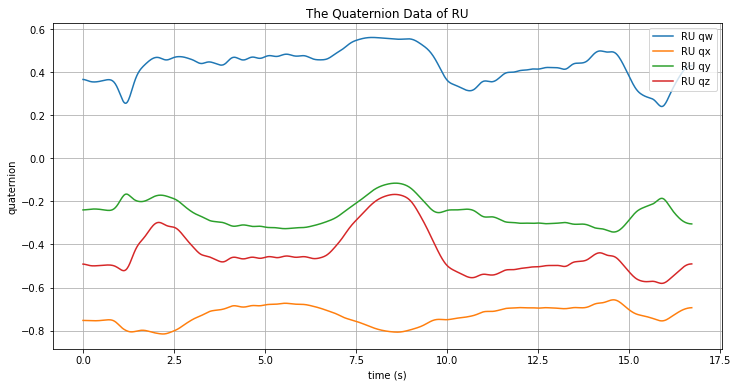

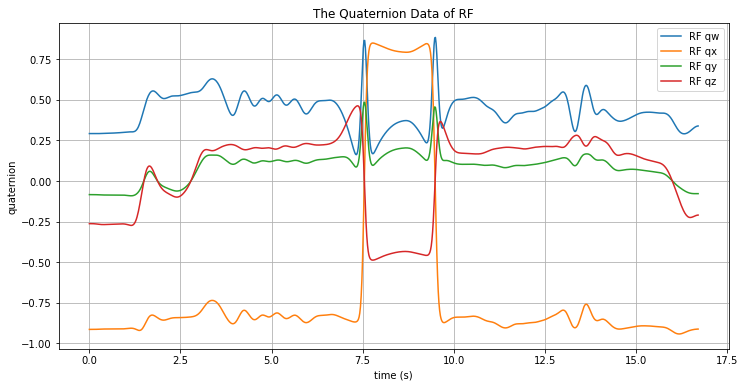

In [172]:
# plot quaternion data
import matplotlib.pyplot as plt

# 读取四元数数据文件
file_path = '../data/s15_arm_quaternions.csv'
quaternion_data = pd.read_csv(file_path)

# 提取RU和RF的四元数数据
ru_quaternion_data = quaternion_data[['RU_qw', 'RU_qx', 'RU_qy', 'RU_qz']].values
rf_quaternion_data = quaternion_data[['RF_qw', 'RF_qx', 'RF_qy', 'RF_qz']].values

# 提取时间数据
time = quaternion_data['time'].values

# 绘制RU和RF的四元数数据
plt.figure(figsize=(12, 6))
plt.plot(time, ru_quaternion_data)
plt.title('The Quaternion Data of RU')
plt.xlabel('time (s)')
plt.ylabel('quaternion')
plt.legend(labels=['RU qw', 'RU qx', 'RU qy', 'RU qz'])
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(time, rf_quaternion_data)
plt.title('The Quaternion Data of RF')
plt.xlabel('time (s)')
plt.ylabel('quaternion')
plt.legend(labels=['RF qw', 'RF qx', 'RF qy', 'RF qz'])
plt.grid()
plt.show()

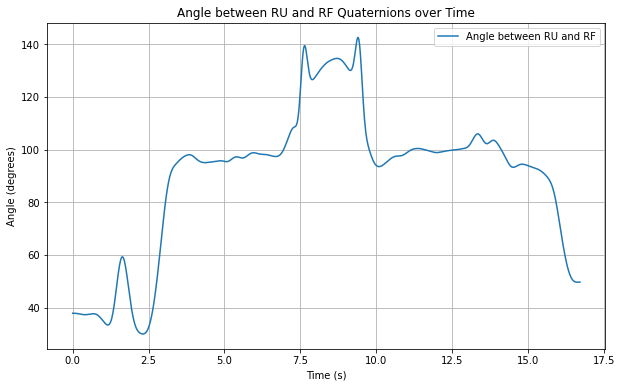

In [174]:
###########################################计算夹角###########################################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Define functions to compute angle between quaternions
def quaternion_conjugate(q):
    """Compute the conjugate of a quaternion."""
    w, x, y, z = q
    return np.array([w, -x, -y, -z])

def quaternion_multiply(q1, q2):
    """Compute the product of two quaternions."""
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1*w2 - x1*x2 - y1*y2 - z1*z2
    x = w1*x2 + x1*w2 + y1*z2 - z1*y2
    y = w1*y2 - x1*z2 + y1*w2 + z1*x2
    z = w1*z2 + x1*y2 - y1*x2 + z1*w2
    return np.array([w, x, y, z])

def angle_between_quaternions(q1, q2):
    """Compute the angle between two quaternions in degrees."""
    # Ensure the quaternions are unit quaternions
    q1 = q1 / np.linalg.norm(q1)
    q2 = q2 / np.linalg.norm(q2)
    # Compute the relative quaternion
    q_rel = quaternion_multiply(quaternion_conjugate(q1), q2)
    # Compute the angle
    angle_rad = 2 * np.arccos(np.clip(q_rel[0], -1.0, 1.0))
    angle_deg = np.degrees(angle_rad)
    # Ensure the angle is between 0 and 180 degrees
    if angle_deg > 180.0:
        angle_deg = 360.0 - angle_deg
    return angle_deg

# Read the CSV file
file_path = '../data/s15_arm_quaternions.csv'
data = pd.read_csv(file_path)

# Extract the time and quaternions
timestamps = data['time'].values
quaternions_ru = data[['RU_qw', 'RU_qx', 'RU_qy', 'RU_qz']].values
quaternions_rf = data[['RF_qw', 'RF_qx', 'RF_qy', 'RF_qz']].values

# Initialize array to store angles
angles = np.zeros(len(timestamps))

# Compute the angle between quaternions at each timestamp
for i in range(len(timestamps)):
    q_ru = quaternions_ru[i]
    q_rf = quaternions_rf[i]
    angle = angle_between_quaternions(q_ru, q_rf)
    angles[i] = angle

# Smooth the angles using a Gaussian filter
angles_smoothed = gaussian_filter1d(angles, sigma=5)
# Plot the angles over time
plt.figure(figsize=(10, 6))
plt.plot(timestamps, angles_smoothed, label='Angle between RU and RF')
plt.xlabel('Time (s)')
plt.ylabel('Angle (degrees)')
plt.title('Angle between RU and RF Quaternions over Time')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
######################################偏移量夹角计算######################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 定义四元数函数
def quaternion_conjugate(q):
    """计算四元数的共轭。"""
    w, x, y, z = q
    return np.array([w, -x, -y, -z])

def quaternion_multiply(q1, q2):
    """计算两个四元数的乘积。"""
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1*w2 - x1*x2 - y1*y2 - z1*z2
    x = w1*x2 + x1*w2 + y1*z2 - z1*y2
    y = w1*y2 - x1*z2 + y1*w2 + z1*x2
    z = w1*z2 + x1*y2 - y1*x2 + z1*w2
    return np.array([w, x, y, z])

def angle_between_quaternions(q1, q2):
    """计算两个四元数之间的旋转角度（单位：度）。"""
    # 确保四元数已规范化
    q1 = q1 / np.linalg.norm(q1)
    q2 = q2 / np.linalg.norm(q2)
    # 计算相对四元数
    q_rel = quaternion_multiply(quaternion_conjugate(q1), q2)
    # 计算角度
    angle_rad = 2 * np.arccos(np.clip(q_rel[0], -1.0, 1.0))
    angle_deg = np.degrees(angle_rad)
    # 确保角度在 [0, 180] 度之间
    if angle_deg > 180.0:
        angle_deg = 360.0 - angle_deg
    return angle_deg

# 读取 CSV 文件
file_path = '/u/44/yangz2/unix/Documents/vs_code_programs/joint_angles/data/stable_quaternions.csv'
data = pd.read_csv(file_path)

# 提取时间戳和四元数
timestamps = data['time'].values
quaternions_ru = data[['RU_qw', 'RU_qx', 'RU_qy', 'RU_qz']].values
quaternions_rf = data[['RF_qw', 'RF_qx', 'RF_qy', 'RF_qz']].values

# 初始化存储夹角的数组
angles = np.zeros(len(timestamps))

# 计算初始夹角偏移
q_ru_initial = quaternions_ru[0]
q_rf_initial = quaternions_rf[0]
initial_angle = angle_between_quaternions(q_ru_initial, q_rf_initial)

# 计算每个时间点的夹角并减去初始偏移
for i in range(len(timestamps)):
    q_ru = quaternions_ru[i]
    q_rf = quaternions_rf[i]
    angle = angle_between_quaternions(q_ru, q_rf)
    adjusted_angle = angle - initial_angle
    # 如果调整后的角度为负值，可以加上360度使其为正
    if adjusted_angle < 0:
        adjusted_angle += 360
    angles[i] = adjusted_angle

# 绘制调整后的夹角曲线
plt.figure(figsize=(10, 6))
plt.plot(timestamps, angles, label='Adjusted Angle between RU and RF')
plt.xlabel('Time (s)')
plt.ylabel('Angle (degrees)')
plt.title('Adjusted Angle between RU and RF Quaternions over Time')
plt.legend()
plt.grid(True)
plt.show()


Gimbal lock detected at index 183, Euler angles: [110.42680474 -88.36255015 -99.82495815]
Gimbal lock detected at index 315, Euler angles: [ 66.55648157  87.44401049 174.88679959]
Gimbal lock detected at index 497, Euler angles: [-143.12451267   86.49596563   85.18311862]
Gimbal lock detected at index 616, Euler angles: [152.46783178 -88.32604091  -3.2807524 ]


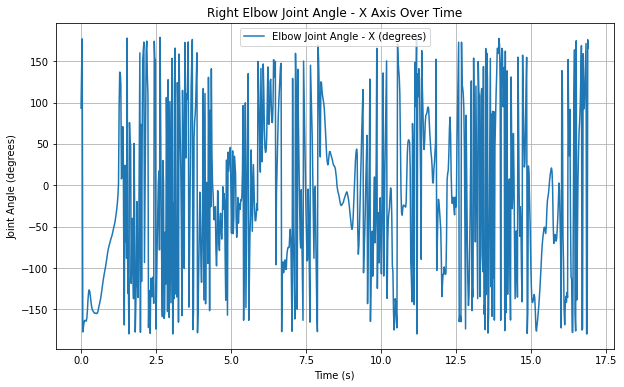

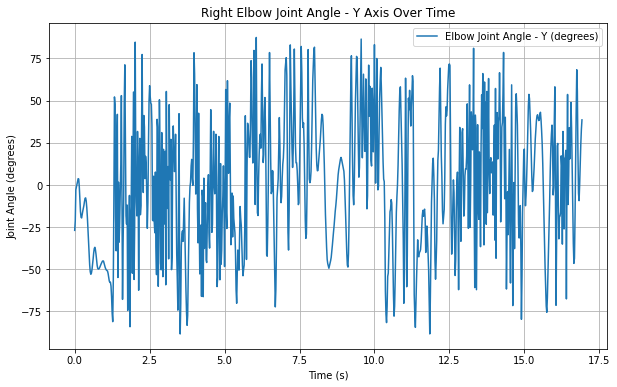

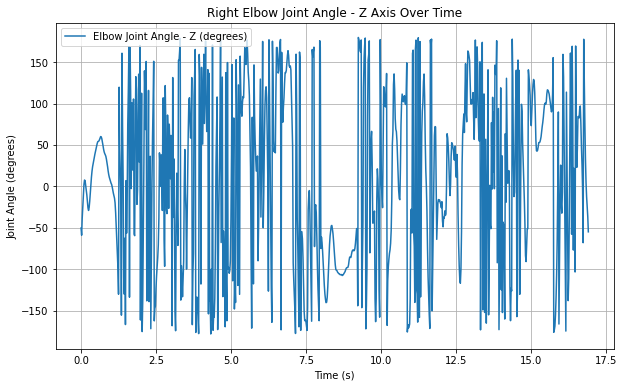

In [17]:
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

# 读取四元数数据文件
file_path = '../data/right_arm_quaternions.csv'
quaternion_data = pd.read_csv(file_path)

# 提取RU和RF的四元数
ru_quaternions = quaternion_data[['RU_qw', 'RU_qx', 'RU_qy', 'RU_qz']].values
rf_quaternions = quaternion_data[['RF_qw', 'RF_qx', 'RF_qy', 'RF_qz']].values

# 初始化存储绕x轴、y轴、z轴角度的列表
joint_angles_x = []
joint_angles_y = []
joint_angles_z = []

# 计算关节角度（假设计算的是肘关节的相对旋转）
for i in range(len(ru_quaternions)):
    # RU和RF的四元数转换为旋转矩阵
    r_ru = R.from_quat(ru_quaternions[i])
    r_rf = R.from_quat(rf_quaternions[i])
    
    # 计算RU相对于RF的相对旋转矩阵
    r_relative = r_ru.inv() * r_rf
    
    # 转换为欧拉角，获取绕x轴、y轴、z轴的角度
    euler_angles = r_relative.as_euler('xyz', degrees=True)
    
    # 检查y轴旋转是否接近±90度
    if abs(euler_angles[1]) > 85:  # y轴接近±90度
        print(f"Gimbal lock detected at index {i}, Euler angles: {euler_angles}")
    
    # 分别存储绕x轴、y轴、z轴的角度
    joint_angles_x.append(euler_angles[0])  # 绕x轴的角度
    joint_angles_y.append(euler_angles[1])  # 绕y轴的角度
    joint_angles_z.append(euler_angles[2])  # 绕z轴的角度

# 生成时间序列，采样率为52Hz
sampling_rate = 52.0
time = np.arange(0, len(joint_angles_x) / sampling_rate, 1 / sampling_rate)

# 绘制绕x轴的关节角度随时间变化的曲线
plt.figure(figsize=(10, 6))
plt.plot(time, joint_angles_x, label='Elbow Joint Angle - X (degrees)')
plt.xlabel('Time (s)')
plt.ylabel('Joint Angle (degrees)')
plt.title('Right Elbow Joint Angle - X Axis Over Time')
plt.legend()
plt.grid(True)
plt.savefig('../graph/right_elbow_x.png')

# 绘制绕y轴的关节角度随时间变化的曲线
plt.figure(figsize=(10, 6))
plt.plot(time, joint_angles_y, label='Elbow Joint Angle - Y (degrees)')
plt.xlabel('Time (s)')
plt.ylabel('Joint Angle (degrees)')
plt.title('Right Elbow Joint Angle - Y Axis Over Time')
plt.legend()
plt.grid(True)
plt.savefig('../graph/right_elbow_y.png')

# 绘制绕z轴的关节角度随时间变化的曲线
plt.figure(figsize=(10, 6))
plt.plot(time, joint_angles_z, label='Elbow Joint Angle - Z (degrees)')
plt.xlabel('Time (s)')
plt.ylabel('Joint Angle (degrees)')
plt.title('Right Elbow Joint Angle - Z Axis Over Time')
plt.legend()
plt.grid(True)
plt.savefig('../graph/right_elbow_z.png')

# 展示图像
plt.show()


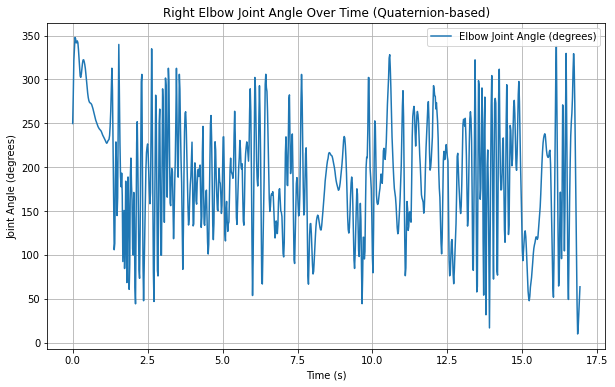

In [18]:
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

# 读取四元数数据文件
file_path = '../data/right_arm_quaternions.csv'
quaternion_data = pd.read_csv(file_path)

# 提取RU和RF的四元数
ru_quaternions = quaternion_data[['RU_qw', 'RU_qx', 'RU_qy', 'RU_qz']].values
rf_quaternions = quaternion_data[['RF_qw', 'RF_qx', 'RF_qy', 'RF_qz']].values

# 初始化存储关节旋转角度的列表
joint_angles = []

# 计算关节的相对旋转角度（基于四元数的相对旋转）
for i in range(len(ru_quaternions)):
    # RU和RF的四元数转换为旋转矩阵
    r_ru = R.from_quat(ru_quaternions[i])
    r_rf = R.from_quat(rf_quaternions[i])
    
    # 计算相对旋转四元数
    r_relative = r_ru.inv() * r_rf
    
    # 提取四元数中的实部
    q_relative = r_relative.as_quat()
    
    # 计算相对旋转角度（弧度）
    angle = 2 * np.arccos(np.clip(q_relative[0], -1.0, 1.0))  # q[0]是四元数的实部
    
    # 将角度转换为度数
    angle_degrees = np.degrees(angle)
    
    joint_angles.append(angle_degrees)

# 生成时间序列，采样率为52Hz
sampling_rate = 52.0
time = np.arange(0, len(joint_angles) / sampling_rate, 1 / sampling_rate)

# 绘制关节角度随时间变化的曲线
plt.figure(figsize=(10, 6))
plt.plot(time, joint_angles, label='Elbow Joint Angle (degrees)')
plt.xlabel('Time (s)')
plt.ylabel('Joint Angle (degrees)')
plt.title('Right Elbow Joint Angle Over Time (Quaternion-based)')
plt.legend()
plt.grid(True)
plt.savefig('../graph/right_elbow_angle_quaternion.png')

plt.show()


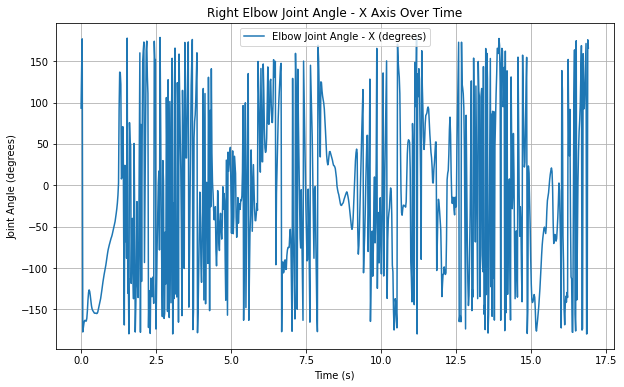

In [19]:
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

# 读取四元数数据文件
file_path = '../data/right_arm_quaternions.csv'
quaternion_data = pd.read_csv(file_path)

# 提取RU和RF的四元数
ru_quaternions = quaternion_data[['RU_qw', 'RU_qx', 'RU_qy', 'RU_qz']].values
rf_quaternions = quaternion_data[['RF_qw', 'RF_qx', 'RF_qy', 'RF_qz']].values

# 初始化存储绕x轴、y轴、z轴角度的列表
joint_angles_x = []
joint_angles_y = []
joint_angles_z = []

# 计算关节角度（假设计算的是肘关节的相对旋转）
for i in range(len(ru_quaternions)):
    # RU和RF的四元数转换为旋转矩阵
    r_ru = R.from_quat(ru_quaternions[i])
    r_rf = R.from_quat(rf_quaternions[i])
    
    # 计算RU相对于RF的相对旋转矩阵
    r_relative = r_ru.inv() * r_rf
    
    # 转换为欧拉角，获取绕x轴、y轴、z轴的角度
    euler_angles = r_relative.as_euler('xyz', degrees=True)
    
    # 检测y轴角度是否接近±90度，若接近，可能出现万向节死锁
    if abs(euler_angles[1]) > 85:
        if joint_angles_x:
            # 在死锁情况下，保持前一帧的值
            joint_angles_x.append(joint_angles_x[-1])
            joint_angles_y.append(joint_angles_y[-1])
            joint_angles_z.append(joint_angles_z[-1])
        else:
            # 如果是第一个点，直接保存当前值
            joint_angles_x.append(euler_angles[0])
            joint_angles_y.append(euler_angles[1])
            joint_angles_z.append(euler_angles[2])
    else:
        # 正常情况下，保存欧拉角
        joint_angles_x.append(euler_angles[0])
        joint_angles_y.append(euler_angles[1])
        joint_angles_z.append(euler_angles[2])

# 生成时间序列，采样率为52Hz
sampling_rate = 52.0
time = np.arange(0, len(joint_angles_x) / sampling_rate, 1 / sampling_rate)

# 绘制绕x轴的关节角度随时间变化的曲线
plt.figure(figsize=(10, 6))
plt.plot(time, joint_angles_x, label='Elbow Joint Angle - X (degrees)')
plt.xlabel('Time (s)')
plt.ylabel('Joint Angle (degrees)')
plt.title('Right Elbow Joint Angle - X Axis Over Time')
plt.legend()
plt.grid(True)
plt.savefig('../graph/right_elbow_x_fixed.png')

plt.show()


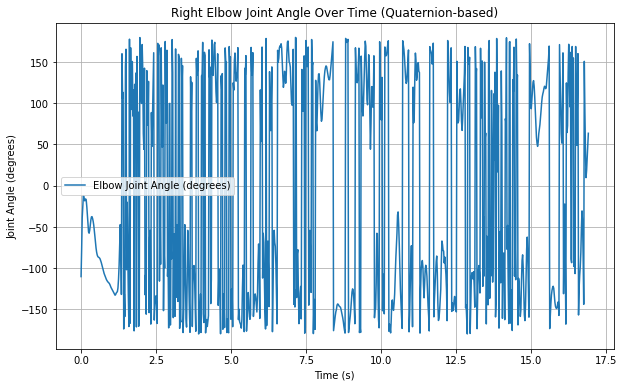

In [20]:
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

# 读取四元数数据文件
file_path = '../data/right_arm_quaternions.csv'
quaternion_data = pd.read_csv(file_path)

# 提取RU和RF的四元数
ru_quaternions = quaternion_data[['RU_qw', 'RU_qx', 'RU_qy', 'RU_qz']].values
rf_quaternions = quaternion_data[['RF_qw', 'RF_qx', 'RF_qy', 'RF_qz']].values

# 初始化存储关节旋转角度的列表
joint_angles = []

# 计算关节的相对旋转角度（基于四元数的相对旋转）
for i in range(len(ru_quaternions)):
    # RU和RF的四元数转换为旋转矩阵
    r_ru = R.from_quat(ru_quaternions[i])
    r_rf = R.from_quat(rf_quaternions[i])
    
    # 计算相对旋转四元数
    r_relative = r_ru.inv() * r_rf
    
    # 提取四元数中的实部
    q_relative = r_relative.as_quat()
    
    # 计算相对旋转角度（弧度）
    angle = 2 * np.arccos(np.clip(q_relative[0], -1.0, 1.0))  # q[0]是四元数的实部
    
    # 将角度转换为度数，并限制范围在 [-180°, 180°]
    angle_degrees = np.degrees(angle)
    if angle_degrees > 180:
        angle_degrees -= 360  # 确保角度在 [-180°, 180°] 之间

    joint_angles.append(angle_degrees)

# 生成时间序列，采样率为52Hz
sampling_rate = 52.0
time = np.arange(0, len(joint_angles) / sampling_rate, 1 / sampling_rate)

# 绘制关节角度随时间变化的曲线
plt.figure(figsize=(10, 6))
plt.plot(time, joint_angles, label='Elbow Joint Angle (degrees)')
plt.xlabel('Time (s)')
plt.ylabel('Joint Angle (degrees)')
plt.title('Right Elbow Joint Angle Over Time (Quaternion-based)')
plt.legend()
plt.grid(True)
plt.savefig('../graph/right_elbow_angle_quaternion.png')

plt.show()


In [21]:
import numpy as np
from scipy.spatial.transform import Rotation as R

# Example quaternion data for two IMUs
# RU: IMU on the upper arm (Quaternion format: [qw, qx, qy, qz])
ru_quaternions = np.array([
    [0.707, 0.0, 0.707, 0.0],  # Example quaternion
    [0.707, 0.0, 0.707, 0.0],  # You should replace this with real data
])

# RF: IMU on the lower arm (Quaternion format: [qw, qx, qy, qz])
rf_quaternions = np.array([
    [0.5, 0.5, 0.5, 0.5],  # Example quaternion
    [0.5, 0.5, 0.5, 0.5],  # You should replace this with real data
])

# Function to calculate relative quaternion and extract joint angle
def calculate_joint_angles(ru_quat, rf_quat):
    # Convert quaternions to Rotation objects
    r_ru = R.from_quat(ru_quat)
    r_rf = R.from_quat(rf_quat)
    
    # Calculate relative rotation (upper arm relative to lower arm)
    r_relative = r_ru.inv() * r_rf
    
    # Convert the relative rotation to Euler angles (in degrees)
    joint_angles = r_relative.as_euler('xyz', degrees=True)  # 'xyz' means we calculate roll, pitch, yaw
    return joint_angles

# Loop through the quaternion data and calculate joint angles for each frame
joint_angles_list = []
for i in range(len(ru_quaternions)):
    joint_angles = calculate_joint_angles(ru_quaternions[i], rf_quaternions[i])
    joint_angles_list.append(joint_angles)
    print(f"Joint angles at frame {i}: {joint_angles}")

# Example output:
# Joint angles at frame 0: [angle_x, angle_y, angle_z]


Joint angles at frame 0: [  0.   0. -90.]
Joint angles at frame 1: [  0.   0. -90.]


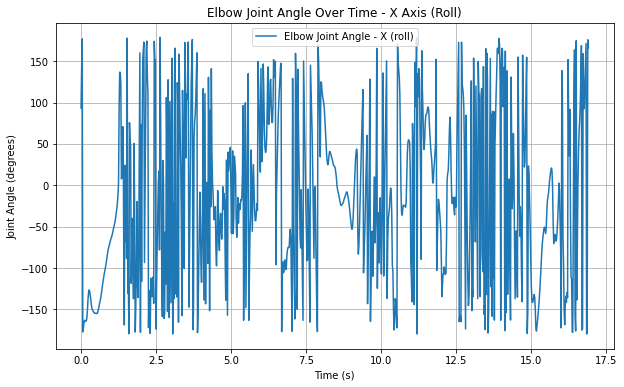

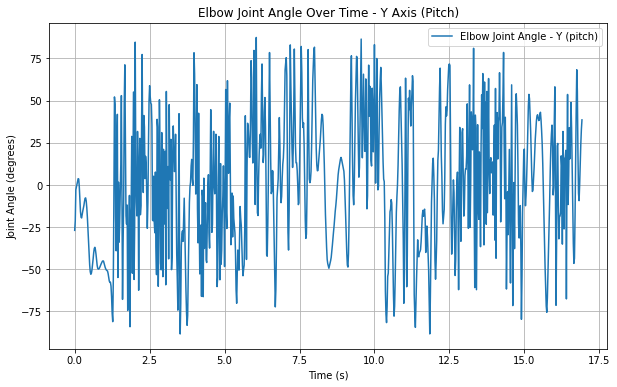

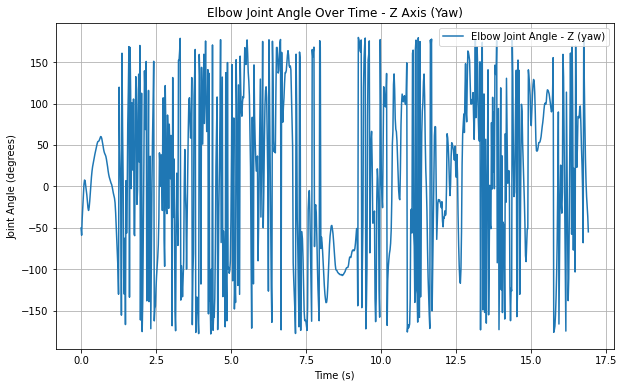

In [22]:
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

# Step 1: Load quaternion data from the CSV file
file_path = '../data/right_arm_quaternions.csv'  # Adjust the path as needed
data = pd.read_csv(file_path)

# Step 2: Extract the quaternions for RU (upper arm) and RF (lower arm)
ru_quaternions = data[['RU_qw', 'RU_qx', 'RU_qy', 'RU_qz']].values
rf_quaternions = data[['RF_qw', 'RF_qx', 'RF_qy', 'RF_qz']].values

# Step 3: Extract the time data
time = data['time'].values

# Function to calculate joint angles from two quaternions
def calculate_joint_angles(ru_quat, rf_quat):
    # Convert quaternions to Rotation objects
    r_ru = R.from_quat(ru_quat)
    r_rf = R.from_quat(rf_quat)
    
    # Calculate relative rotation (upper arm relative to lower arm)
    r_relative = r_ru.inv() * r_rf
    
    # Convert the relative rotation to Euler angles (in degrees)
    joint_angles = r_relative.as_euler('xyz', degrees=True)  # 'xyz' means roll, pitch, yaw
    return joint_angles

# Step 4: Calculate joint angles for each time step
joint_angles_x = []
joint_angles_y = []
joint_angles_z = []

for i in range(len(ru_quaternions)):
    joint_angles = calculate_joint_angles(ru_quaternions[i], rf_quaternions[i])
    joint_angles_x.append(joint_angles[0])  # X-axis (roll)
    joint_angles_y.append(joint_angles[1])  # Y-axis (pitch)
    joint_angles_z.append(joint_angles[2])  # Z-axis (yaw)

# Step 5: Plot the results

# Plot for X-axis (roll)
plt.figure(figsize=(10, 6))
plt.plot(time, joint_angles_x, label='Elbow Joint Angle - X (roll)')
plt.xlabel('Time (s)')
plt.ylabel('Joint Angle (degrees)')
plt.title('Elbow Joint Angle Over Time - X Axis (Roll)')
plt.legend()
plt.grid(True)
plt.savefig('../graph/right_elbow_angle_x.png')  # Save plot for x-axis
plt.show()

# Plot for Y-axis (pitch)
plt.figure(figsize=(10, 6))
plt.plot(time, joint_angles_y, label='Elbow Joint Angle - Y (pitch)')
plt.xlabel('Time (s)')
plt.ylabel('Joint Angle (degrees)')
plt.title('Elbow Joint Angle Over Time - Y Axis (Pitch)')
plt.legend()
plt.grid(True)
plt.savefig('../graph/right_elbow_angle_y.png')  # Save plot for y-axis
plt.show()

# Plot for Z-axis (yaw)
plt.figure(figsize=(10, 6))
plt.plot(time, joint_angles_z, label='Elbow Joint Angle - Z (yaw)')
plt.xlabel('Time (s)')
plt.ylabel('Joint Angle (degrees)')
plt.title('Elbow Joint Angle Over Time - Z Axis (Yaw)')
plt.legend()
plt.grid(True)
plt.savefig('../graph/right_elbow_angle_z.png')  # Save plot for z-axis
plt.show()


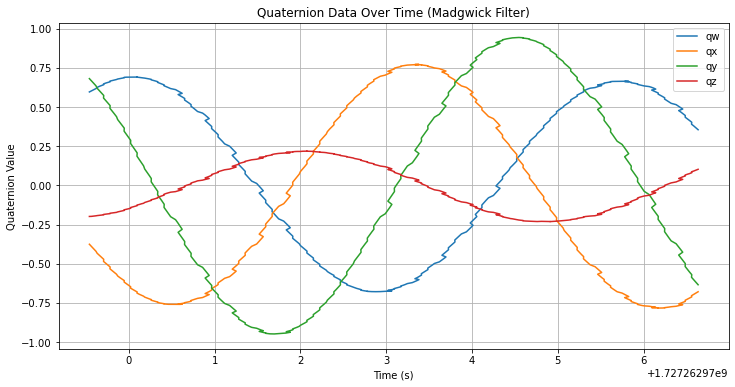

In [85]:
import pandas as pd
import numpy as np
from ahrs.filters import Madgwick
import matplotlib.pyplot as plt

# 读取原始IMU9数据文件
file_path = '/u/44/yangz2/unix/Documents/vs_code_programs/joint_angles/data/merge_2.csv'
data = pd.read_csv(file_path)

# 提取时间戳和IMU传感器数据
timestamps = data['timestamp'].values

# 提取加速度计、陀螺仪和磁力计的数据
acc_data = data[['RU_IMU9_Acc_X','RU_IMU9_Acc_Y','RU_IMU9_Acc_Z']].values  # 假设加速度计数据的列名为acc_x, acc_y, acc_z
gyro_data = data[['RU_IMU9_Gyro_X', 'RU_IMU9_Gyro_Y', 'RU_IMU9_Gyro_Z']].values  # 假设陀螺仪数据的列名为gyro_x, gyro_y, gyro_z
mag_data = data[['RU_IMU9_Magn_X', 'RU_IMU9_Magn_Y', 'RU_IMU9_Magn_Z']].values  # 假设磁力计数据的列名为mag_x, mag_y, mag_z

# 初始化Madgwick滤波器
madgwick = Madgwick(frequency=52.0)  # 根据实际采样频率设定

# 初始化四元数根据前10帧的数据



# 存储四元数的数组
quaternions = np.zeros((len(data), 4))

# 计算四元数
for i in range(len(data)):
    q = madgwick.updateMARG(q, gyr=gyro_data[i], acc=acc_data[i], mag=mag_data[i])
    quaternions[i] = q

# 绘制四元数随时间变化的图形
plt.figure(figsize=(12, 6))
plt.plot(timestamps, quaternions[:, 0], label='qw')
plt.plot(timestamps, quaternions[:, 1], label='qx')
plt.plot(timestamps, quaternions[:, 2], label='qy')
plt.plot(timestamps, quaternions[:, 3], label='qz')
plt.title('Quaternion Data Over Time (Madgwick Filter)')
plt.xlabel('Time (s)')
plt.ylabel('Quaternion Value')
plt.legend()
plt.grid(True)
plt.show()


In [88]:
import numpy as np
from ahrs.filters import Madgwick
import pandas as pd
from scipy.ndimage import gaussian_filter1d

# 读取stable.csv文件
file_path = '../data/merge_2.csv'  # 请修改为你实际的文件路径
data = pd.read_csv(file_path)

# 时间戳列
timestamps = data['timestamp'].values

# 选择RU的加速度计、陀螺仪和磁力计的数据
acc_ru = data[['RU_IMU9_Acc_X', 'RU_IMU9_Acc_Y', 'RU_IMU9_Acc_Z']].values
gyro_ru = data[['RU_IMU9_Gyro_X', 'RU_IMU9_Gyro_Y', 'RU_IMU9_Gyro_Z']].values
mag_ru = data[['RU_IMU9_Magn_X', 'RU_IMU9_Magn_Y', 'RU_IMU9_Magn_Z']].values

# 对RU的加速度和陀螺仪数据应用高斯滤波以减少噪声
acc_ru_smoothed = gaussian_filter1d(acc_ru, sigma=2, axis=0)
gyro_ru_smoothed = gaussian_filter1d(gyro_ru, sigma=2, axis=0)

# 定义计算初始四元数的函数
def calculate_initial_quaternion(acc_data, mag_data):
    # 计算前10帧加速度计和磁力计的平均值
    acc_mean = np.mean(acc_data[:10], axis=0)
    mag_mean = np.mean(mag_data[:10], axis=0)
    
    # 根据加速度计数据计算 pitch 和 roll
    pitch = np.arctan2(acc_mean[1], np.sqrt(acc_mean[0]**2 + acc_mean[2]**2))
    roll = np.arctan2(-acc_mean[0], acc_mean[2])
    
    # 根据磁力计数据计算 yaw
    yaw = np.arctan2(mag_mean[1], mag_mean[0])
    
    # 将欧拉角转换为四元数
    qw = np.cos(roll/2) * np.cos(pitch/2) * np.cos(yaw/2) + np.sin(roll/2) * np.sin(pitch/2) * np.sin(yaw/2)
    qx = np.sin(roll/2) * np.cos(pitch/2) * np.cos(yaw/2) - np.cos(roll/2) * np.sin(pitch/2) * np.sin(yaw/2)
    qy = np.cos(roll/2) * np.sin(pitch/2) * np.cos(yaw/2) + np.sin(roll/2) * np.cos(pitch/2) * np.sin(yaw/2)
    qz = np.cos(roll/2) * np.cos(pitch/2) * np.sin(yaw/2) - np.sin(roll/2) * np.sin(pitch/2) * np.cos(yaw/2)
    
    return np.array([qw, qx, qy, qz])

# 计算RU初始四元数
q_ru = calculate_initial_quaternion(acc_ru, mag_ru)
print("initial quaternion for RU:", q_ru)

# 校正陀螺仪漂移
gyro_bias_ru = np.mean(gyro_ru[:10], axis=0)
gyro_ru_corrected = gyro_ru_smoothed - gyro_bias_ru

# 初始化滤波器，增加beta以减少陀螺仪漂移的影响
madgwick = Madgwick(beta=0.5, frequency=52.0)

# 存储四元数
quaternions_ru = np.zeros((len(data), 4))

# 计算RU的四元数
for i in range(len(data)):
    q_ru = madgwick.updateIMU(q_ru, gyr=gyro_ru_corrected[i], acc=acc_ru_smoothed[i])
    quaternions_ru[i] = q_ru

# 将数据组合到一起
combined_data = np.column_stack((timestamps, 
                                 quaternions_ru[:, 0], quaternions_ru[:, 1], quaternions_ru[:, 2], quaternions_ru[:, 3]))

# 创建DataFrame并保存
columns = ['time', 'RU_qw', 'RU_qx', 'RU_qy', 'RU_qz']
quaternions_df = pd.DataFrame(combined_data, columns=columns)

# 存储四元数到stable_quaternions.csv文件
output_file_path = '../data/merge_2_quaternions.csv'  # 请修改为实际路径
quaternions_df.to_csv(output_file_path, index=False)


initial quaternion for RU: [-0.01131205 -0.59323175  0.80489848 -0.00930424]
